# **Modelling**

In [1]:
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
SALES_DATA_PATH = Path("/content/drive/MyDrive/quamet/Sales Forecasting/df_sales_corrected.csv")
num_features = 45
FEATURES_DATA_PATH = Path(f"/content/drive/MyDrive/quamet/Sales Forecasting/data_additional_63_features.feather")
df_sales = pd.read_csv(SALES_DATA_PATH, parse_dates=["date"])
df_features = pd.read_feather(FEATURES_DATA_PATH)

In [3]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 27.9 MB


In [4]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 63 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   date                                 913000 non-null  datetime64[ns]
 1   store                                913000 non-null  int64         
 2   item                                 913000 non-null  int64         
 3   sales                                913000 non-null  float64       
 4   last_1_days_sales                    912500 non-null  float64       
 5   last_7_days_sales                    909500 non-null  float64       
 6   last_14_days_sales                   906000 non-null  float64       
 7   last_21_days_sales                   902500 non-null  float64       
 8   last_28_days_sales                   899000 non-null  float64       
 9   last_90_days_sales                   868000 non-null  float64       
 

## **Split train and validation data for ts**

In [5]:
def split_time_series_data(df, target_col="sales", date_col="date", split_date=None):
    """
    Split time series data into training and validation sets based on a specified date.

    Parameters:
    - df (pd.DataFrame): The time series DataFrame sorted by date.
    - target_col (str): The name of the target variable. Default is "sales".
    - date_col (str): The name of the date column. Default is "date".
    - split_date (str): The date used to split the data into training and validation sets.

    Returns:
    - pd.DataFrame, pd.Series, pd.DataFrame, pd.Series: X_train, y_train, X_val, y_val

    Example:
    ```python
    # Assuming df_preprocessed is the time series DataFrame
    X_train, y_train, X_val, y_val = split_time_series_data(df_preprocessed, split_date='2017-10-01')
    ```

    Note:
    - Make sure that the DataFrame is sorted by date before using this function.
    """
    # Ensure the DataFrame is sorted by date
    df_sorted = df.sort_values(date_col).reset_index(drop=True)

    # Train-Validation Split
    train_set = df_sorted.loc[df_sorted[date_col] < split_date, :]
    val_set = df_sorted.loc[
        (df_sorted[date_col] >= split_date)
        & (df_sorted[date_col] <= df_sorted[date_col].max()),
        :,
    ]

    # Extract features and target variables
    feature_cols = [
        col for col in df_sorted.columns if col not in [date_col, target_col]
    ]

    X_train = train_set[feature_cols]
    X_val = val_set[feature_cols]
    y_val = val_set[target_col]
    y_train = train_set[target_col]

    return X_train, X_val, y_train, y_val

In [6]:
X_train, X_val, y_train, y_val = split_time_series_data(
    df_features, split_date="2017-10-01")

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((867000, 61), (867000,), (46000, 61), (46000,))

## **Simple model**

### **Define the custom evaluation function for SMAPE**

In [10]:
def symmetric_mean_absolute_percentage_error(predictions, targets):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
    - predictions: Predicted values.
    - targets: Actual target values.

    Returns:
    - SMAPE value.
    """
    non_zero_mask = ~((predictions == 0) & (targets == 0))
    predictions, targets = predictions[non_zero_mask], targets[non_zero_mask]

    absolute_errors = np.abs(predictions - targets)
    absolute_sum = np.abs(predictions) + np.abs(targets)

    smape_value = 200 * np.mean(absolute_errors / absolute_sum)
    return smape_value


In [11]:
# Sample check
predictions = np.array([20, 30, 40, 50])
targets = np.array([25, 35, 45, 55])

# Calculate SMAPE
smape_value = symmetric_mean_absolute_percentage_error(predictions, targets)

# Print the results
print("Predictions:", predictions)
print("Targets:", targets)
print("SMAPE:", smape_value)


Predictions: [20 30 40 50]
Targets: [25 35 45 55]
SMAPE: 14.723838253250019


In [12]:
def lgbm_smape_evaluation(y_true, y_pred):
    """
    LightGBM custom evaluation function for SMAPE.

    Parameters:
    - y_true: Actual target values.
    - y_pred: Predicted values.

    Returns:
    - Tuple containing evaluation metric name, SMAPE value
    """
    smape_value = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return smape_value

### **Train a simple model**

In [16]:
def train_and_evaluate_lgbm(
    X_train, y_train, X_val, y_val, custom_metric, model_params=None
):
    """
    Create, train, and evaluate the LightGBM regression model with the custom evaluation metric.

    Parameters:
    - X_train, Y_train: Training data and target.
    - X_val, Y_val: Validation data and target.
    - custom_metric: Custom evaluation metric function.
    - model_params: Optional parameters for the LightGBM model.

    Returns:
    - Trained LightGBM model.
    """
    if model_params is None:
        model_params = {"random_state": 42}

    # Create and train a LightGBM model
    lgb_model = lgb.LGBMRegressor(**model_params)
    lgb_model.fit(X_train, y_train, eval_metric=custom_metric)

    # Evaluate and print SMAPE on the training set
    train_smape = custom_metric(y_train, lgb_model.predict(X_train))
    print("TRAIN SMAPE:", train_smape)

    # Evaluate and print SMAPE on the validation set
    valid_smape = custom_metric(y_val, lgb_model.predict(X_val))
    print("VALID SMAPE:", valid_smape)

    return lgb_model

In [17]:
# Training
simple_model = train_and_evaluate_lgbm(
    X_train, y_train, X_val, y_val, custom_metric=lgbm_smape_evaluation
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.103358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13097
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 61
[LightGBM] [Info] Start training from score 51.945933
TRAIN SMAPE: 12.822267781268579
VALID SMAPE: 12.938203071458068


### **Visualize the importances of features**

In [18]:
def get_lgb_importances(model, num=10):
    gain = model.booster_.feature_importance(importance_type="gain")
    feat_imp = pd.DataFrame(
        {
            "feature": model.feature_name_,
            "split": model.booster_.feature_importance(importance_type="split"),
            "gain": 100 * gain / gain.sum(),
        }
    ).sort_values("gain", ascending=False)

    return feat_imp.head(num)


def show_importance_plot(feature_imp_df, figsize=(8, 6)):
    sns.set(font_scale=1)
    plt.figure(figsize=figsize)
    sns.barplot(x="gain", y="feature", data=feature_imp_df, color="r")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [19]:
get_lgb_importances(simple_model, num=30)

,feature,split,gain
9,recent_7_days_mean_sales,616,80.624256
36,sales_ewma_0.75_alpha_7_days_sales,25,4.499560
42,sales_ewma_0.9_alpha_7_days_sales,33,2.459914
30,sales_ewma_0.5_alpha_7_days_sales,19,2.070042
43,sales_ewma_0.9_alpha_14_days_sales,19,1.934545
29,sales_ewma_0.5_alpha_3_days_sales,587,1.423584
5,last_21_days_sales,92,1.385569
6,last_28_days_sales,82,1.062634
3,last_7_days_sales,76,0.961639
4,last_14_days_sales,67,0.892604


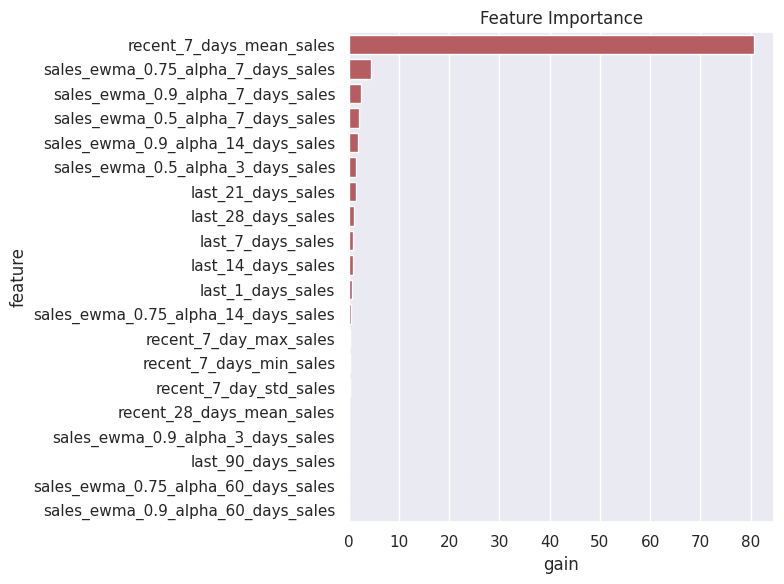

In [20]:
show_importance_plot(get_lgb_importances(simple_model, num=20))

### **Parameter tuning**

In [21]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [22]:
import optuna


def objective(trial, df, custom_metric):
    """
    Objective function for Optuna optimization.

    Parameters:
    - trial: Optuna Trial object.
    - X: Training data.
    - y: Target variable.
    - custom_metric: Custom evaluation metric function.

    Returns:
    - SMAPE value to minimize.
    """
    # Split the data for training and validation
    X_train, X_val, y_train, y_val = split_time_series_data(df, split_date="2017-10-01")

    # Define hyperparameters to optimize
    params = {
        "objective": "regression",
        "metric": "custom",
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["gbdt", "dart", "goss"]
        ),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1),
    }

    # Exclude bagging parameters when boosting_type is 'goss'
    if params["boosting_type"] != "goss":
        params["bagging_fraction"] = trial.suggest_float("bagging_fraction", 0.1, 1)
        params["bagging_freq"] = trial.suggest_int("bagging_freq", 1, 10)

    # Create and train LightGBM model
    lgb_model = lgb.LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train, eval_metric=custom_metric)

    # Evaluate using the validation set and return the SMAPE
    val_smape = custom_metric(y_val, lgb_model.predict(X_val))
    return val_smape

In [23]:
def optimize_lightgbm(X, y, custom_metric, n_trials=50):
    study = optuna.create_study(direction="minimize")
    objective_fn = lambda trial: objective(trial, df_features, custom_metric)

    # Optimize the objective function
    study.optimize(objective_fn, n_trials=n_trials)

    # Print study trials and statuses
    for trial in study.trials:
        print(f"Trial #{trial.number}, Status: {trial.state}, Value: {trial.value}")

    if len(study.trials) == 0 or all(
        trial.state == optuna.trial.TrialState.FAIL for trial in study.trials
    ):
        raise ValueError("No successful trials have been completed.")

    # Get the best hyperparameters
    best_params = study.best_params

    return best_params

In [24]:
# Example usage:
best_params = optimize_lightgbm(
    X_train, y_train, custom_metric=lgbm_smape_evaluation, n_trials=30
)

[I 2024-11-07 15:53:41,146] A new study created in memory with name: no-name-6ea9cbc0-7bc7-4a7e-b32d-6739b9412e67


[LightGBM] [Warning] feature_fraction is set=0.9424300251164025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9424300251164025
[LightGBM] [Warning] bagging_fraction is set=0.14258806838834642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14258806838834642
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9424300251164025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9424300251164025
[LightGBM] [Warning] bagging_fraction is set=0.14258806838834642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14258806838834642
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.682932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 15:54:35,143] Trial 0 finished with value: 15.392789094889656 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'learning_rate': 0.0970275126933843, 'feature_fraction': 0.9424300251164025, 'bagging_fraction': 0.14258806838834642, 'bagging_freq': 4}. Best is trial 0 with value: 15.392789094889656.


[LightGBM] [Warning] feature_fraction is set=0.16464583013361578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16464583013361578
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.16464583013361578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16464583013361578
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13097
[

[I 2024-11-07 15:55:06,564] Trial 1 finished with value: 13.56654148225844 and parameters: {'boosting_type': 'goss', 'num_leaves': 97, 'learning_rate': 0.0882985549409038, 'feature_fraction': 0.16464583013361578}. Best is trial 1 with value: 13.56654148225844.


[LightGBM] [Warning] feature_fraction is set=0.9708830345006974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9708830345006974
[LightGBM] [Warning] bagging_fraction is set=0.7380785433251783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7380785433251783
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9708830345006974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9708830345006974
[LightGBM] [Warning] bagging_fraction is set=0.7380785433251783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7380785433251783
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.082720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-11-07 15:56:28,606] Trial 2 finished with value: 15.57311518319585 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.09309891411423865, 'feature_fraction': 0.9708830345006974, 'bagging_fraction': 0.7380785433251783, 'bagging_freq': 4}. Best is trial 1 with value: 13.56654148225844.


[LightGBM] [Warning] feature_fraction is set=0.42566714896261604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42566714896261604
[LightGBM] [Warning] bagging_fraction is set=0.6468424276449904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6468424276449904
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.42566714896261604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42566714896261604
[LightGBM] [Warning] bagging_fraction is set=0.6468424276449904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6468424276449904
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.569257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 15:56:54,065] Trial 3 finished with value: 13.594910205475513 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'learning_rate': 0.09004662197469092, 'feature_fraction': 0.42566714896261604, 'bagging_fraction': 0.6468424276449904, 'bagging_freq': 8}. Best is trial 1 with value: 13.56654148225844.


[LightGBM] [Warning] feature_fraction is set=0.3198325747985781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3198325747985781
[LightGBM] [Warning] bagging_fraction is set=0.6568640665575307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6568640665575307
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.3198325747985781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3198325747985781
[LightGBM] [Warning] bagging_fraction is set=0.6568640665575307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6568640665575307
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.542581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-11-07 15:57:21,057] Trial 4 finished with value: 14.141556725481413 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'learning_rate': 0.04330855075952769, 'feature_fraction': 0.3198325747985781, 'bagging_fraction': 0.6568640665575307, 'bagging_freq': 7}. Best is trial 1 with value: 13.56654148225844.


[LightGBM] [Warning] feature_fraction is set=0.6457393680915432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6457393680915432
[LightGBM] [Warning] bagging_fraction is set=0.31444906149472196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31444906149472196
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6457393680915432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6457393680915432
[LightGBM] [Warning] bagging_fraction is set=0.31444906149472196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31444906149472196
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.031012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 15:57:49,770] Trial 5 finished with value: 12.781130624835003 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'learning_rate': 0.08220152516909944, 'feature_fraction': 0.6457393680915432, 'bagging_fraction': 0.31444906149472196, 'bagging_freq': 6}. Best is trial 5 with value: 12.781130624835003.


[LightGBM] [Warning] feature_fraction is set=0.7251155462441818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7251155462441818
[LightGBM] [Warning] bagging_fraction is set=0.987483734640986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987483734640986
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7251155462441818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7251155462441818
[LightGBM] [Warning] bagging_fraction is set=0.987483734640986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987483734640986
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.054596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2024-11-07 15:58:41,369] Trial 6 finished with value: 13.54236105228098 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'learning_rate': 0.04100526539608678, 'feature_fraction': 0.7251155462441818, 'bagging_fraction': 0.987483734640986, 'bagging_freq': 4}. Best is trial 5 with value: 12.781130624835003.


[LightGBM] [Warning] feature_fraction is set=0.37128247690462557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37128247690462557
[LightGBM] [Warning] bagging_fraction is set=0.12160534861199712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12160534861199712
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.37128247690462557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37128247690462557
[LightGBM] [Warning] bagging_fraction is set=0.12160534861199712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12160534861199712
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.553458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [

[I 2024-11-07 15:59:28,880] Trial 7 finished with value: 17.149464188282312 and parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'learning_rate': 0.07766900098434767, 'feature_fraction': 0.37128247690462557, 'bagging_fraction': 0.12160534861199712, 'bagging_freq': 7}. Best is trial 5 with value: 12.781130624835003.


[LightGBM] [Warning] feature_fraction is set=0.9769279208878698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9769279208878698
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.9769279208878698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9769279208878698
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13097
[Ligh

[I 2024-11-07 15:59:57,880] Trial 8 finished with value: 14.087712310923855 and parameters: {'boosting_type': 'goss', 'num_leaves': 10, 'learning_rate': 0.08336817241105615, 'feature_fraction': 0.9769279208878698}. Best is trial 5 with value: 12.781130624835003.


[LightGBM] [Warning] feature_fraction is set=0.30479078342283594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30479078342283594
[LightGBM] [Warning] bagging_fraction is set=0.782108438829236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782108438829236
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.30479078342283594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30479078342283594
[LightGBM] [Warning] bagging_fraction is set=0.782108438829236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782108438829236
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.506993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-11-07 16:01:12,680] Trial 9 finished with value: 39.990211391190314 and parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'learning_rate': 0.01212811815951051, 'feature_fraction': 0.30479078342283594, 'bagging_fraction': 0.782108438829236, 'bagging_freq': 4}. Best is trial 5 with value: 12.781130624835003.


[LightGBM] [Warning] feature_fraction is set=0.6341187944204398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6341187944204398
[LightGBM] [Warning] bagging_fraction is set=0.3638041377817813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3638041377817813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6341187944204398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6341187944204398
[LightGBM] [Warning] bagging_fraction is set=0.3638041377817813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3638041377817813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.603324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-11-07 16:01:47,478] Trial 10 finished with value: 12.935174349557412 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'learning_rate': 0.06308017118303114, 'feature_fraction': 0.6341187944204398, 'bagging_fraction': 0.3638041377817813, 'bagging_freq': 1}. Best is trial 5 with value: 12.781130624835003.


[LightGBM] [Warning] feature_fraction is set=0.674526911788769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.674526911788769
[LightGBM] [Warning] bagging_fraction is set=0.3703862097675137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3703862097675137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.674526911788769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.674526911788769
[LightGBM] [Warning] bagging_fraction is set=0.3703862097675137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3703862097675137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.591989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2024-11-07 16:02:21,950] Trial 11 finished with value: 12.901673574093259 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'learning_rate': 0.06092086494139123, 'feature_fraction': 0.674526911788769, 'bagging_fraction': 0.3703862097675137, 'bagging_freq': 1}. Best is trial 5 with value: 12.781130624835003.


[LightGBM] [Warning] feature_fraction is set=0.7543231396952589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543231396952589
[LightGBM] [Warning] bagging_fraction is set=0.3849620694208165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3849620694208165
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7543231396952589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543231396952589
[LightGBM] [Warning] bagging_fraction is set=0.3849620694208165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3849620694208165
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.036481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-11-07 16:02:56,326] Trial 12 finished with value: 12.780378735087242 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'learning_rate': 0.06584660511900785, 'feature_fraction': 0.7543231396952589, 'bagging_fraction': 0.3849620694208165, 'bagging_freq': 2}. Best is trial 12 with value: 12.780378735087242.


[LightGBM] [Warning] feature_fraction is set=0.8121157569019324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121157569019324
[LightGBM] [Warning] bagging_fraction is set=0.38897913774571335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38897913774571335
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8121157569019324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121157569019324
[LightGBM] [Warning] bagging_fraction is set=0.38897913774571335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38897913774571335
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.607255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [

[I 2024-11-07 16:03:31,031] Trial 13 finished with value: 12.680746524355174 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'learning_rate': 0.07459726768697568, 'feature_fraction': 0.8121157569019324, 'bagging_fraction': 0.38897913774571335, 'bagging_freq': 10}. Best is trial 13 with value: 12.680746524355174.


[LightGBM] [Warning] feature_fraction is set=0.8133261372964716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8133261372964716
[LightGBM] [Warning] bagging_fraction is set=0.48284086082299477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48284086082299477
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8133261372964716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8133261372964716
[LightGBM] [Warning] bagging_fraction is set=0.48284086082299477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48284086082299477
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.632903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 16:04:10,414] Trial 14 finished with value: 12.64719275935415 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'learning_rate': 0.06800435160410169, 'feature_fraction': 0.8133261372964716, 'bagging_fraction': 0.48284086082299477, 'bagging_freq': 9}. Best is trial 14 with value: 12.64719275935415.


[LightGBM] [Warning] feature_fraction is set=0.8314421195961489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8314421195961489
[LightGBM] [Warning] bagging_fraction is set=0.5094888858525779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5094888858525779
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8314421195961489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8314421195961489
[LightGBM] [Warning] bagging_fraction is set=0.5094888858525779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5094888858525779
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.597925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 16:04:53,252] Trial 15 finished with value: 12.889709811008753 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'learning_rate': 0.048336423813274805, 'feature_fraction': 0.8314421195961489, 'bagging_fraction': 0.5094888858525779, 'bagging_freq': 10}. Best is trial 14 with value: 12.64719275935415.


[LightGBM] [Warning] feature_fraction is set=0.5165107642587724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165107642587724
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5165107642587724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165107642587724
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13097
[Ligh

[I 2024-11-07 16:05:29,371] Trial 16 finished with value: 12.905771341047057 and parameters: {'boosting_type': 'goss', 'num_leaves': 66, 'learning_rate': 0.07264445231030621, 'feature_fraction': 0.5165107642587724}. Best is trial 14 with value: 12.64719275935415.


[LightGBM] [Warning] feature_fraction is set=0.8470135929528243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8470135929528243
[LightGBM] [Warning] bagging_fraction is set=0.5036450971645144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5036450971645144
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8470135929528243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8470135929528243
[LightGBM] [Warning] bagging_fraction is set=0.5036450971645144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5036450971645144
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.614765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 16:06:11,857] Trial 17 finished with value: 13.676380257169502 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'learning_rate': 0.031678873347132, 'feature_fraction': 0.8470135929528243, 'bagging_fraction': 0.5036450971645144, 'bagging_freq': 10}. Best is trial 14 with value: 12.64719275935415.


[LightGBM] [Warning] feature_fraction is set=0.8434433441752847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8434433441752847
[LightGBM] [Warning] bagging_fraction is set=0.261037015026498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.261037015026498
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8434433441752847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8434433441752847
[LightGBM] [Warning] bagging_fraction is set=0.261037015026498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.261037015026498
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.613346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2024-11-07 16:06:42,728] Trial 18 finished with value: 12.52548943127865 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'learning_rate': 0.07202139740970465, 'feature_fraction': 0.8434433441752847, 'bagging_fraction': 0.261037015026498, 'bagging_freq': 9}. Best is trial 18 with value: 12.52548943127865.


[LightGBM] [Warning] feature_fraction is set=0.5346321872698021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5346321872698021
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5346321872698021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5346321872698021
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13097
[Ligh

[I 2024-11-07 16:07:21,355] Trial 19 finished with value: 12.835683006453847 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'learning_rate': 0.054209968985582155, 'feature_fraction': 0.5346321872698021}. Best is trial 18 with value: 12.52548943127865.


[LightGBM] [Warning] feature_fraction is set=0.8756119983687143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8756119983687143
[LightGBM] [Warning] bagging_fraction is set=0.23453662802216185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23453662802216185
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8756119983687143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8756119983687143
[LightGBM] [Warning] bagging_fraction is set=0.23453662802216185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23453662802216185
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.669879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 16:07:51,872] Trial 20 finished with value: 13.657757067249419 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'learning_rate': 0.03256777749347859, 'feature_fraction': 0.8756119983687143, 'bagging_fraction': 0.23453662802216185, 'bagging_freq': 8}. Best is trial 18 with value: 12.52548943127865.


[LightGBM] [Warning] feature_fraction is set=0.779564739483627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779564739483627
[LightGBM] [Warning] bagging_fraction is set=0.24448687139939873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24448687139939873
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.779564739483627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779564739483627
[LightGBM] [Warning] bagging_fraction is set=0.24448687139939873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24448687139939873
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.771261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-11-07 16:08:19,013] Trial 21 finished with value: 12.797161056931227 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'learning_rate': 0.07281023359180686, 'feature_fraction': 0.779564739483627, 'bagging_fraction': 0.24448687139939873, 'bagging_freq': 9}. Best is trial 18 with value: 12.52548943127865.


[LightGBM] [Warning] feature_fraction is set=0.8721198633804945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8721198633804945
[LightGBM] [Warning] bagging_fraction is set=0.4527967213179504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4527967213179504
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8721198633804945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8721198633804945
[LightGBM] [Warning] bagging_fraction is set=0.4527967213179504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4527967213179504
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.618318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-11-07 16:08:57,656] Trial 22 finished with value: 12.512711070026164 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'learning_rate': 0.07149227625586109, 'feature_fraction': 0.8721198633804945, 'bagging_fraction': 0.4527967213179504, 'bagging_freq': 9}. Best is trial 22 with value: 12.512711070026164.


[LightGBM] [Warning] feature_fraction is set=0.9275160684704522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275160684704522
[LightGBM] [Warning] bagging_fraction is set=0.48412425910008666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48412425910008666
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.9275160684704522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275160684704522
[LightGBM] [Warning] bagging_fraction is set=0.48412425910008666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48412425910008666
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.624200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 16:09:40,960] Trial 23 finished with value: 12.633425904002646 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'learning_rate': 0.05818047861021273, 'feature_fraction': 0.9275160684704522, 'bagging_fraction': 0.48412425910008666, 'bagging_freq': 9}. Best is trial 22 with value: 12.512711070026164.


[LightGBM] [Warning] feature_fraction is set=0.9040885665801431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9040885665801431
[LightGBM] [Warning] bagging_fraction is set=0.24609523855326018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24609523855326018
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9040885665801431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9040885665801431
[LightGBM] [Warning] bagging_fraction is set=0.24609523855326018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24609523855326018
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.048008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-11-07 16:10:12,840] Trial 24 finished with value: 12.715301214711463 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'learning_rate': 0.055254575933542154, 'feature_fraction': 0.9040885665801431, 'bagging_fraction': 0.24609523855326018, 'bagging_freq': 8}. Best is trial 22 with value: 12.512711070026164.


[LightGBM] [Warning] feature_fraction is set=0.900674744817042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900674744817042
[LightGBM] [Warning] bagging_fraction is set=0.5714644316780947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5714644316780947
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.900674744817042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900674744817042
[LightGBM] [Warning] bagging_fraction is set=0.5714644316780947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5714644316780947
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.609108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2024-11-07 16:10:58,785] Trial 25 finished with value: 12.697601484840309 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'learning_rate': 0.05535504578130268, 'feature_fraction': 0.900674744817042, 'bagging_fraction': 0.5714644316780947, 'bagging_freq': 9}. Best is trial 22 with value: 12.512711070026164.


[LightGBM] [Warning] feature_fraction is set=0.9995696822728947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995696822728947
[LightGBM] [Warning] bagging_fraction is set=0.4637354161401072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4637354161401072
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9995696822728947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995696822728947
[LightGBM] [Warning] bagging_fraction is set=0.4637354161401072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4637354161401072
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.620916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-11-07 16:11:42,997] Trial 26 finished with value: 12.55476252440823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'learning_rate': 0.06005585695707751, 'feature_fraction': 0.9995696822728947, 'bagging_fraction': 0.4637354161401072, 'bagging_freq': 6}. Best is trial 22 with value: 12.512711070026164.


[LightGBM] [Warning] feature_fraction is set=0.9840594171537882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9840594171537882
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.9840594171537882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9840594171537882
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.639598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13097
[LightGBM] [Info] Number of data points in the train set: 867000, num

[I 2024-11-07 16:12:29,076] Trial 27 finished with value: 12.461760788221948 and parameters: {'boosting_type': 'goss', 'num_leaves': 79, 'learning_rate': 0.06860456285091968, 'feature_fraction': 0.9840594171537882}. Best is trial 27 with value: 12.461760788221948.


[LightGBM] [Warning] feature_fraction is set=0.5810935060198993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5810935060198993
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5810935060198993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5810935060198993
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13097
[Ligh

[I 2024-11-07 16:13:06,870] Trial 28 finished with value: 12.592365096782904 and parameters: {'boosting_type': 'goss', 'num_leaves': 80, 'learning_rate': 0.07925882643129815, 'feature_fraction': 0.5810935060198993}. Best is trial 27 with value: 12.461760788221948.


[LightGBM] [Warning] feature_fraction is set=0.7042564768422532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7042564768422532
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7042564768422532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7042564768422532
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.605201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13097
[LightGBM] [Info] Number of data points in the train set: 867000, num

[I 2024-11-07 16:13:47,837] Trial 29 finished with value: 12.149860857096657 and parameters: {'boosting_type': 'goss', 'num_leaves': 99, 'learning_rate': 0.0975115762145142, 'feature_fraction': 0.7042564768422532}. Best is trial 29 with value: 12.149860857096657.


Trial #0, Status: 1, Value: 15.392789094889656
Trial #1, Status: 1, Value: 13.56654148225844
Trial #2, Status: 1, Value: 15.57311518319585
Trial #3, Status: 1, Value: 13.594910205475513
Trial #4, Status: 1, Value: 14.141556725481413
Trial #5, Status: 1, Value: 12.781130624835003
Trial #6, Status: 1, Value: 13.54236105228098
Trial #7, Status: 1, Value: 17.149464188282312
Trial #8, Status: 1, Value: 14.087712310923855
Trial #9, Status: 1, Value: 39.990211391190314
Trial #10, Status: 1, Value: 12.935174349557412
Trial #11, Status: 1, Value: 12.901673574093259
Trial #12, Status: 1, Value: 12.780378735087242
Trial #13, Status: 1, Value: 12.680746524355174
Trial #14, Status: 1, Value: 12.64719275935415
Trial #15, Status: 1, Value: 12.889709811008753
Trial #16, Status: 1, Value: 12.905771341047057
Trial #17, Status: 1, Value: 13.676380257169502
Trial #18, Status: 1, Value: 12.52548943127865
Trial #19, Status: 1, Value: 12.835683006453847
Trial #20, Status: 1, Value: 13.657757067249419
Trial #

In [25]:
print(best_params)

{'boosting_type': 'goss', 'num_leaves': 99, 'learning_rate': 0.0975115762145142, 'feature_fraction': 0.7042564768422532}


In [26]:
# Training better model
better_model = train_and_evaluate_lgbm(
    X_train,
    y_train,
    X_val,
    y_val,
    custom_metric=lgbm_smape_evaluation,
    model_params=best_params,
)

[LightGBM] [Warning] feature_fraction is set=0.7042564768422532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7042564768422532
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7042564768422532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7042564768422532
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.598033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13097
[LightGBM] [Info] Number of data points in the train set: 867000, num

In [28]:
def save_model(model, file_path):
    import pickle
    from lightgbm import LGBMRegressor
    """
    Save a machine learning model to a file.

    Parameters:
    - model: The trained model (sklearn or lightgbm).
    - file_path: The file path where the model will be saved.
    """
    if isinstance(model, LGBMRegressor):
        # For LightGBM scikit-learn API models
        model.booster_.save_model(file_path)
        print(f"LightGBM (scikit-learn API) model saved to {file_path}")
    else:
        # For scikit-learn models
        with open(file_path, 'wb') as file:
            pickle.dump(model, file)
        print(f"Sklearn model saved to {file_path}")

In [32]:
model_version = "01"
nums_features = 63
model_path= f"/content/drive/MyDrive/quamet/Sales Forecasting/sales_forecasting_model_{nums_features}_features_v{model_version}.txt"
save_model(better_model,file_path=model_path)

LightGBM (scikit-learn API) model saved to /content/drive/MyDrive/quamet/Sales Forecasting/sales_forecasting_model_63_features_v01.txt


In [30]:
def save_data(df, file_path, file_format="feather"):
    """
    Save a DataFrame to a specified file format.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be saved.
    - file_path (str): The path where the file will be saved.
    - file_format (str): The format in which to save the file. Supported formats: 'feather', 'csv'.
                        Default is 'feather'.
    Example:
    ```python
    # Assuming df is the DataFrame you want to save
    save_data(df, 'output_data.feather', file_format='feather')
    ```

    Note:
    - Make sure to have the required libraries (pandas and feather-format) installed.
    """
    if file_format.lower() == "feather":
        # Save to Feather format
        df.to_feather(file_path)
        print(f"DataFrame saved to {file_path} in Feather format.")
    elif file_format.lower() == "csv":
        # Save to CSV format
        df.to_csv(file_path, index=False)
        print(f"DataFrame saved to {file_path} in CSV format.")
    else:
        print(f"Error: Unsupported file format '{file_format}'. Supported formats: 'feather', 'csv'.")


In [33]:
save_data(X_val.reset_index(), file_path=f"../content/drive/MyDrive/quamet/Sales Forecasting/X_val_{nums_features}_features.feather")
save_data(y_val.reset_index(), file_path=f"../content/drive/MyDrive/quamet/Sales Forecasting/y_val_{nums_features}_features.feather")

DataFrame saved to ../content/drive/MyDrive/quamet/Sales Forecasting/X_val_63_features.feather in Feather format.
DataFrame saved to ../content/drive/MyDrive/quamet/Sales Forecasting/y_val_63_features.feather in Feather format.
